In [1]:
import torch
import pandas as pd
import numpy as np
import importlib
import ModelRunner as MR
import MakeDataset as MD
import SiameseNeuralNetwork as SNN
from matplotlib import pyplot as plt

In [2]:
# Load the dataset. 
# molecule_features: First col is a string containing name of molecule. Rest are floats containing its features
# eutectic_compilation: First 2 cols are strings containing molecule names, third col is eutectic proportion, fourth is eutectic temperature

molecule_features = pd.read_csv("D:\\Research\\UConn_ML\\data\\eutectic_mixtures-main\\single_components.csv").drop(["xlogp"], axis=1)
eutectic_compilation = pd.read_csv("D:\\Research\\UConn_ML\\data\\eutectic_mixtures-main\\eutectic_compilation.csv")

molecule_features[molecule_features.columns[1:]] = molecule_features[molecule_features.columns[1:]].astype(float)
eutectic_compilation[eutectic_compilation.columns[3]] = eutectic_compilation[eutectic_compilation.columns[3]].astype(float)

In [3]:
# Some indices in eutectic_compilation do not exist in single_components. They will need to be removed.
# Some of the eutectic proportions are inconvertible to floats from strings. They will also need to be removed.
# missing_molecules will store all molecules that are missing features from eutectic_compilation
drops = np.array([]).astype(int)
missing_molecules = np.array([]).astype(str)
for i in range(len(eutectic_compilation)):
    ec = eutectic_compilation.iloc[i]
    m1 = ec[0]
    m2 = ec[1]
    xe = ec[2]
    
    m1f = molecule_features.loc[molecule_features.mol == ec[0]]
    m2f = molecule_features.loc[molecule_features.mol == ec[1]]
    
    try:
        xe = float(xe)
    except ValueError:
        drops = np.append(drops, i)
    
    if(len(m1f) == 0 or len(m2f) == 0):
        drops = np.append(drops, i)
        
        if(len(m1f) == 0):
            missing_molecules = np.append(missing_molecules, m1)
        elif(len(m2f) == 0):
            missing_molecules = np.append(missing_molecules, m2)

eutectic_compilation = eutectic_compilation.drop(eutectic_compilation.index[drops])
# np.savetxt("missing_molecules.csv", missing_molecules, delimiter=",", fmt="%s")

In [4]:
# Split the eutectic compilation dataframe by a ratio into training and testing sets
split = 0.95
train_ec = eutectic_compilation.sample(frac=split)
test_ec = eutectic_compilation.drop(train_ec.index)

split = 0.10
val_ec = train_ec.sample(frac=split)
train_ec = train_ec.drop(val_ec.index)

In [5]:
molecule_features

,mol,molecular_weight,complexity,rotatable_bond_count,heavy_atom_count,topological_area
0,BaO,153.3300,2.0,0.0,2.0,17.1
1,CrCl3,158.3500,0.0,0.0,4.0,0.0
2,PBr5,430.4900,37.1,0.0,6.0,0.0
3,WCl5,361.1000,37.1,0.0,6.0,0.0
4,HgI2,454.4000,2.8,0.0,3.0,0.0
...,...,...,...,...,...,...
672,PBr3,270.6900,8.0,0.0,4.0,0.0
673,PbSiO3,283.0000,18.8,0.0,5.0,63.2
674,LiI,133.9000,2.0,0.0,2.0,0.0
675,EuF3,208.9590,8.0,0.0,4.0,0.0


In [6]:
eutectic_compilation

,molA,molB,xe,Te
0,BF3,N2O,76.6,-138.0
1,BF3,SO2,95.2,-128.6
2,BCl3,GeCl4,76,-116.0
3,BCl3,PCl3,94,-110.0
4,BCl3,PCl3,20,-99.0
...,...,...,...,...
4463,Sc2O3,ZrO2,52.2,2450.0
4464,UO2,ZrO2,47.5,2550.0
4465,UO2,ZrO2,50,2550.0
4466,UN,W,100,2700.0


In [7]:
train_ec

,molA,molB,xe,Te
1937,NaCl,NiSO4,75,500.0
2668,KCl,TiCl2,73,632.0
1116,KNO3,TlCl,88.9,305.0
4275,Al2O3,Ce2O3,68,1750.0
78,FeCl3,ReOCl4,0,29.0
...,...,...,...,...
3908,BaF2,BaSO4,67,958.0
479,NH4Cl,SnCl2,42,173.0
2003,K2SO4,MoO3,22,510.0
2636,CsF,KF,57,625.0


In [8]:
val_ec

,molA,molB,xe,Te
4436,BeO,ThO2,79,2175.0
1666,AgCl,Li2WO4,99,449.0
4058,FeS,ZnS,6,1135.0
2715,CaCl2,CeCl3,76,640.0
2052,CrCl2,RbCl,24.5,523.0
...,...,...,...,...
970,LiBr,RbBr,55,273.0
2813,BaCl2,NaCl,39.9,654.0
712,LiCl,SnCl2,15,215.0
4027,Cr2O3,FeO,72.8,1090.0


In [9]:
test_ec

,molA,molB,xe,Te
23,AsBr3,S2Br2,13.5,-56.0
30,Si2OCl6,TiCl4,42,-50.0
47,GeBr4,POCl3,36,-16.0
64,ICl,TaCl5,80,10.0
101,AlBr3,SbCl3,14.5,54.0
...,...,...,...,...
4333,Gd2O3,SiO2,45,1850.0
4373,Cr2O3,Sm2O3,20,1980.0
4390,BeO,ZrO2,59,2045.0
4435,Gd2O3,ZrO2,86,2175.0


In [10]:
print(molecule_features.columns)
print(eutectic_compilation.columns)

Index(['mol', 'molecular_weight', 'complexity', 'rotatable_bond_count',
       'heavy_atom_count', 'topological_area'],
      dtype='object')
Index(['molA', 'molB', 'xe', 'Te'], dtype='object')


In [11]:
print(molecule_features.dtypes)
print(eutectic_compilation.dtypes)

mol                      object
molecular_weight        float64
complexity              float64
rotatable_bond_count    float64
heavy_atom_count        float64
topological_area        float64
dtype: object
molA     object
molB     object
xe       object
Te      float64
dtype: object


In [12]:
molecule_features.iloc[0]

mol                        BaO
molecular_weight        153.33
complexity                 2.0
rotatable_bond_count       0.0
heavy_atom_count           2.0
topological_area          17.1
Name: 0, dtype: object

In [13]:
print("Train Size: ", len(train_ec))
print("Validation Size: ", len(val_ec))
print("Test Size: ", len(test_ec))

Train Size:  3403
Validation Size:  378
Test Size:  199


In [14]:
importlib.reload(MD)

<module 'MakeDataset' from 'D:\\Research\\UConn_ML\\Code\\MakeDataset.py'>

In [95]:
# Define parameters and datasets to pass into trainer. Pass in order of definition
starting_features = 5
batchsize = 30
max_epochs = 30
lrmin = 1e-8
lrmax = 5e-4
train_dset = MD.MD(train_ec, molecule_features, starting_features)
val_dset = MD.MD(val_ec, molecule_features, starting_features)
test_dset = MD.MD(test_ec, molecule_features, starting_features)

# Set the baselines for training, validation, and testing
# MSE is basically variance, so the baseline is the variance of the dataset
train_var = torch.std(torch.tensor(np.array(train_ec["xe"]).astype(float) / 100.0))**2
# train_mean = torch.mean(torch.tensor(np.array(train_ec["Te"])))

train_param = "xe"

In [123]:
# Call training and testing class and send all required parameters 
importlib.reload(MR)
importlib.reload(SNN)
modelrunner = MR.MR(starting_features, batchsize, max_epochs, lrmin, lrmax, 
                    train_dset, val_dset, test_dset, train_var, train_param)

trloss, trbase, vloss, vbase = modelrunner.train_and_validate()
outputs, invouts, truths = modelrunner.test_plot_stats()

C:\Users\arjun\anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 | Train Loss: 0.111558 | Train Baseline: 0.258108 | Val Loss: 0.103038 | Val Baseline: 0.257803
Epoch 2 | Train Loss: 0.112291 | Train Baseline: 0.258108 | Val Loss: 0.102983 | Val Baseline: 0.257803
Epoch 3 | Train Loss: 0.112275 | Train Baseline: 0.258108 | Val Loss: 0.102878 | Val Baseline: 0.257803
Epoch 4 | Train Loss: 0.112126 | Train Baseline: 0.258108 | Val Loss: 0.102716 | Val Baseline: 0.257803
Epoch 5 | Train Loss: 0.111979 | Train Baseline: 0.258108 | Val Loss: 0.102488 | Val Baseline: 0.257803
Epoch 6 | Train Loss: 0.111636 | Train Baseline: 0.258108 | Val Loss: 0.102178 | Val Baseline: 0.257803
Epoch 7 | Train Loss: 0.111215 | Train Baseline: 0.258108 | Val Loss: 0.101786 | Val Baseline: 0.257803
Epoch 8 | Train Loss: 0.111263 | Train Baseline: 0.258108 | Val Loss: 0.101475 | Val Baseline: 0.257803
Epoch 9 | Train Loss: 0.110915 | Train Baseline: 0.258108 | Val Loss: 0.101088 | Val Baseline: 0.257803
Epoch 10 | Train Loss: 0.110242 | Train Baseline: 0.258108 | Val

C:\Users\arjun\anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Loss: 0.115 | Test Baseline: 0.252



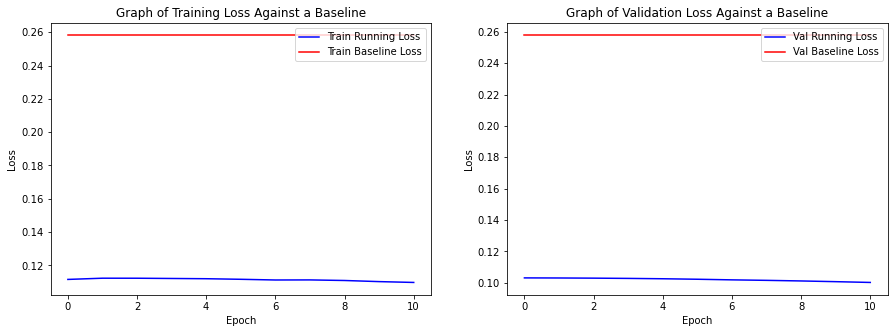

In [124]:
l = len(trloss)
x = np.arange(l)
fig, axes = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)
            
axes[0].plot(x, trloss[0:l], label="Train Running Loss", c="blue")
axes[0].plot(x, trbase[0:l], label="Train Baseline Loss", c="red")
axes[0].set_title("Graph of Training Loss Against a Baseline")
axes[0].set(xlabel="Epoch", ylabel="Loss")
axes[0].legend(loc="upper right")

axes[1].plot(x, vloss[0:l], label="Val Running Loss", c="blue")
axes[1].plot(x, vbase[0:l], label="Val Baseline Loss", c="red")
axes[1].set_title("Graph of Validation Loss Against a Baseline")
axes[1].set(xlabel="Epoch", ylabel="Loss")
axes[1].legend(loc="upper right")

plt.show()

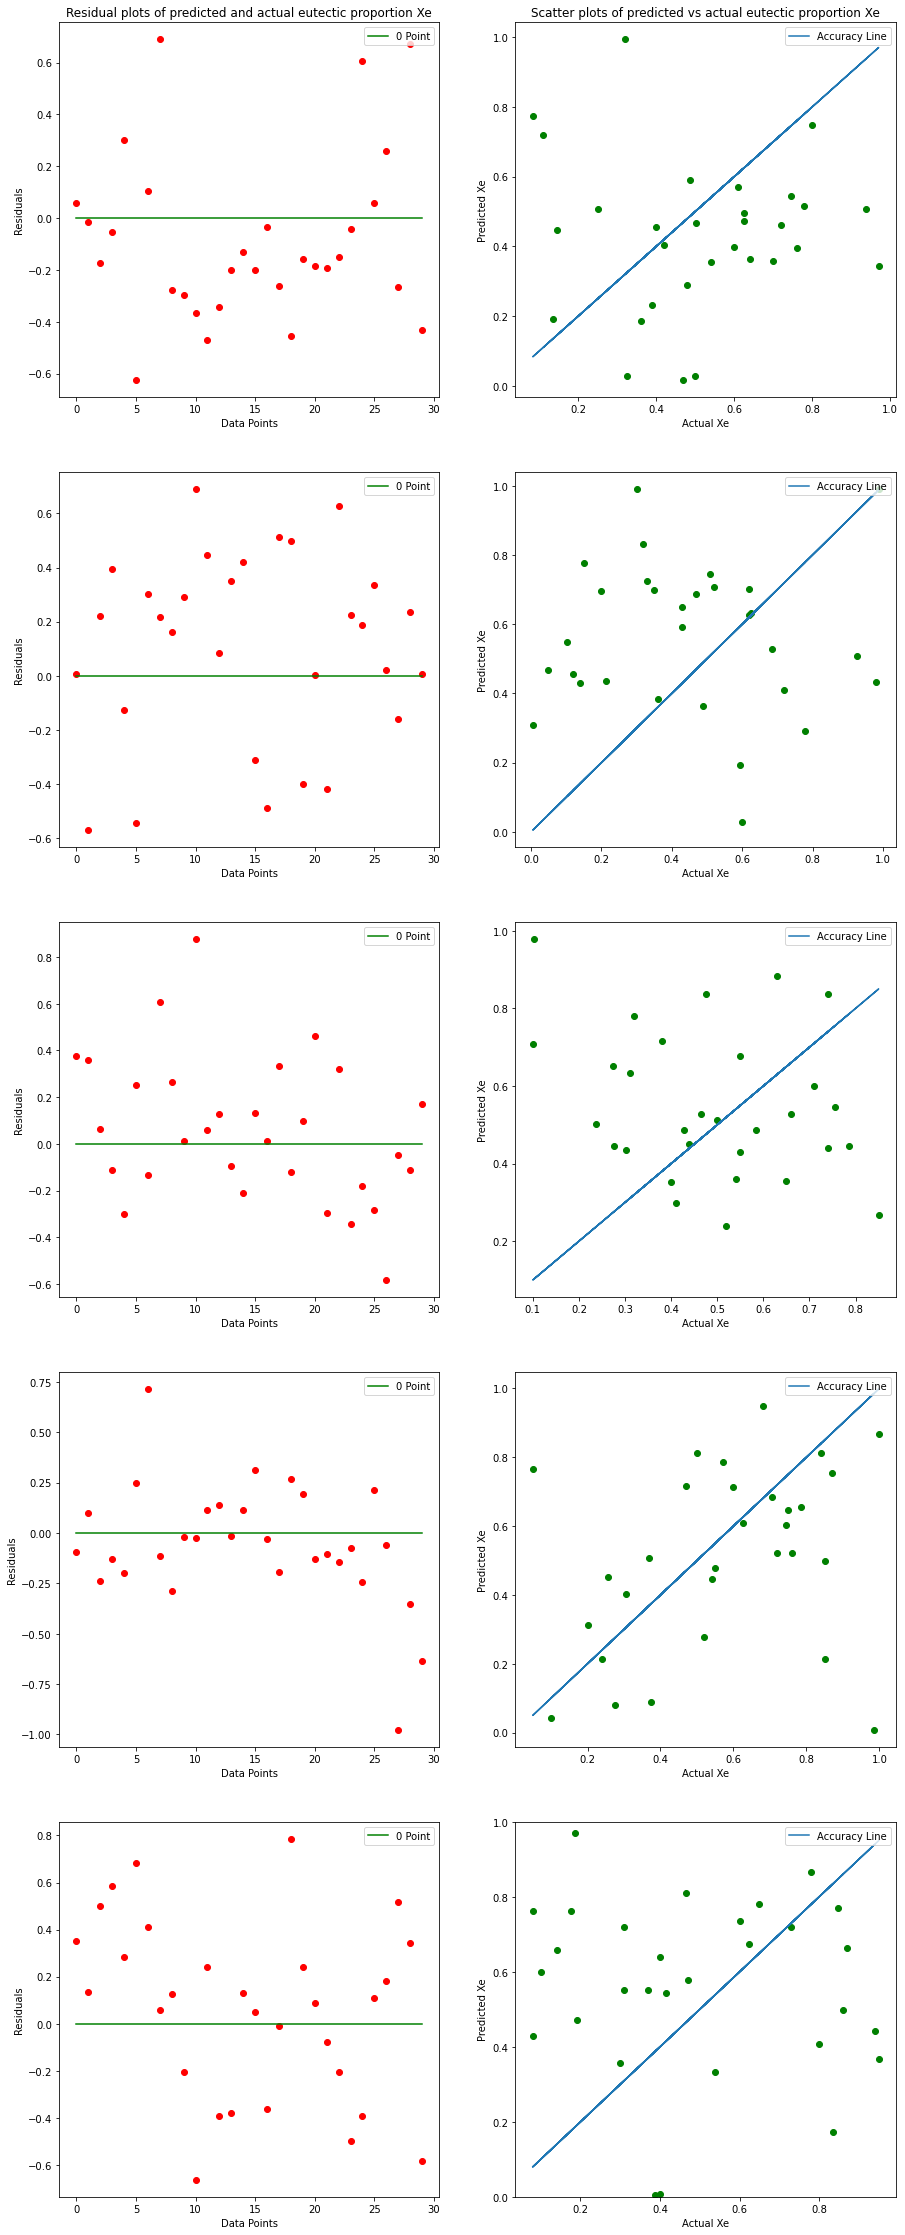

In [125]:
fig, axes = plt.subplots(5, 2)
fig.set_figheight(40)
fig.set_figwidth(15)

l = batchsize
pred = 0
succ = 1
x = np.arange(l)
        
for row in range(5):
    axes[row, 0].scatter(x, outputs[pred*l:succ*l] - truths[pred*l:succ*l], c="red")
    axes[row, 0].plot(x, np.zeros((l,)), c="green", label="0 Point")
    axes[row, 0].set(xlabel="Data Points", ylabel="Residuals")
    axes[row, 0].legend(loc="upper right")

    axes[row, 1].scatter(truths[pred*l:succ*l], outputs[pred*l:succ*l], c="green")
    axes[row, 1].plot(truths[pred*l:succ*l], truths[pred*l:succ*l], label="Accuracy Line")
    axes[row, 1].set(xlabel="Actual Xe", ylabel="Predicted Xe")
    axes[row, 1].legend(loc="upper right")

    plt.ylim([0, 1])
            
    pred += 1
    succ += 1
    
axes[0, 0].set_title("Residual plots of predicted and actual eutectic proportion Xe")
axes[0, 1].set_title("Scatter plots of predicted vs actual eutectic proportion Xe")
plt.show()

In [126]:
# Print the values from the last batch processed just for the user to see
disp = pd.DataFrame({
    'f(A,B)': np.round(outputs[0:l], 3),
    'f(B,A)': np.round(invouts[0:l], 3),
    'f(A,B) + f(B,A)': outputs[0:l] + invouts[0:l],
    'Truth': np.round(truths[0:l], 3),
    'Pred': np.round(outputs[0:l], 3)})
        
disp.style.set_properties(**{'width': '150px'})

,"f(A,B)","f(B,A)","f(A,B) + f(B,A)",Truth,Pred
0,0.192000,0.808000,1.000000,0.135000,0.192000
1,0.406000,0.594000,1.000000,0.420000,0.406000
2,0.186000,0.814000,1.000000,0.360000,0.186000
3,0.747000,0.253000,1.000000,0.800000,0.747000
4,0.448000,0.552000,1.000000,0.145000,0.448000
5,0.345000,0.655000,1.000000,0.970000,0.345000
6,0.591000,0.409000,1.000000,0.486000,0.591000
7,0.773000,0.227000,1.000000,0.084000,0.773000
8,0.364000,0.636000,1.000000,0.640000,0.364000
9,0.029000,0.971000,1.000000,0.325000,0.029000


In [128]:
# fig.savefig('D:\\Research\\UConn_ML\\Images\\plots4_7_13_22.png')